<a href="https://colab.research.google.com/github/GerardoToso/Competencia-FSadosky-e-YPF-/blob/main/03_Baseline_OIL_and_GAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="float:left; border:none">
   <tr style="border:none">
       <td style="border:none">  
           <img 
               src="" 
               style="width:10px"
           >
           </a>    
       </td>
   </tr>
</table>
<div style="float:right;"><h2>03. Baseline OIL and GAS</h2></div>

 <a id="top"></a> <br>
## Índice
1. [Entradas y Entregable](#1)<br>
    1.1. [Entradas del modelo](#11)<br>
    1.2. [Entregable](#12)<br>
2. [Carga de paquetes y datos](#2)<br>
    2.1. [Librerías y clases](#21)<br>
    2.2. [Lectura de datos](#22)<br>
    2.3. [Separación de OIL y GAS](#23)<br>
    2.4. [Separación en train y test](#24)<br>
3. [Modelo](#3)<br>
    3.1. [Confección pipeline](#31)<br>
    3.2. [Optimización de hiperparámetros](#32)<br>

***
<a id="1"></a> <br>
## 1. Entradas y Entregable

<a id="11"></a>
### 1.1. Entradas

|Tipo|Nombre|Descripción|Ubicación Lab|
|:-------|----------------|---------------------------------------------------|-------------------------------------|
|**csv**| `Dataset participantes.csv` | datos relacionados con los pozos al producirse una interferencia por la estimulación de un pozo hijo |`/content/drive/MyDrive/DataScience/TRABAJOS PARTICULARES/YPF/DATASET/`|

<a id="12"></a>
### 1.2. Entregable

**Archivo csv con las estimaciones de delta_WHP**

***
<a id="2"></a> <br>
## 2. Carga de paquetes y datos

<a id="21"></a>
### 2.1. Librerías y clases

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import lightgbm as lgb

import chardet

import warnings
warnings.filterwarnings("ignore")

In [17]:
# Esta clase permite dropear columnas de un DataFrame dentro de un pipeline

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self  

In [18]:
# Esta función grafica los residuos de las predicciones del modelo
def diag_residuos (y, X,model):

    # Diagnóstico errores (residuos) de las predicciones de entrenamiento
    # ==============================================================================
    prediccion = model.predict(X)
    residuos   = prediccion - y
    # Gráficos
    # ==============================================================================
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 15))

    axes[0, 0].scatter(y, prediccion, edgecolors=(0, 0, 0), alpha = 0.4)
    axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()],'k--', color = 'black', lw=2)
    axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
    axes[0, 0].set_xlabel('Real')
    axes[0, 0].set_ylabel('Predicción')
    axes[0, 0].tick_params(labelsize = 7)

    axes[0, 1].scatter(list(range(len(y))), residuos, edgecolors=(0, 0, 0), alpha = 0.4)
    axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
    axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
    axes[0, 1].set_xlabel('id')
    axes[0, 1].set_ylabel('Residuo')
    axes[0, 1].tick_params(labelsize = 7)

    sns.histplot( data = residuos, stat = "density", kde = True, line_kws= {'linewidth': 1}, color = "firebrick", alpha   = 0.3, ax = axes[1, 0])

    axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10, fontweight = "bold")
    axes[1, 0].set_xlabel("Residuo")
    axes[1, 0].tick_params(labelsize = 7)


    sm.qqplot( residuos, fit = True, line  = 'q', ax = axes[1, 1], color = 'firebrick', alpha = 0.4, lw = 2 )

    axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
    axes[1, 1].tick_params(labelsize = 7)

    axes[2, 0].scatter(prediccion, residuos, edgecolors=(0, 0, 0), alpha = 0.4)
    axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
    axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
    axes[2, 0].set_xlabel('Predicción')
    axes[2, 0].set_ylabel('Residuo')
    axes[2, 0].tick_params(labelsize = 7)

    # Se eliminan los axes vacíos
    fig.delaxes(axes[2,1])

    fig.tight_layout()
    plt.subplots_adjust(top=0.9)
    fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

<a id="22"></a> <br>
### 2.2. Lectura de datos

In [19]:
# Detección automática de la codificación de los caracteres
with open("/content/drive/MyDrive/DataScience/TRABAJOS PARTICULARES/YPF/DATASET/Dataset evaluación.csv", 'rb') as f:
    enc = chardet.detect(f.read())  # or readline if the file is large

# Lectura del csv
df = pd.read_csv("/content/drive/MyDrive/DataScience/TRABAJOS PARTICULARES/YPF/DATASET/Dataset evaluación.csv", encoding = enc['encoding'], index_col=0)

df.sample(5)

,ID_EVENTO,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D3D,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,delta_WHP,ESTADO
ID_FILA,,,,,,,,,,,,,,,,
22394,Pozo 161-Pozo 159-21,Campo D,OIL,PAD-53,Pozo 161,21,Pozo 159,144.822022,135.332363,51.561320,265.638862,0,NO,243.0,0.6,Cerrado
4455,Pozo 405-Pozo 19-23,Campo F,OIL,PAD-60,Pozo 405,23,Pozo 19,1321.834042,1321.795477,-10.097147,48.398717,4,NO,40.1,0.0,Abierto
10320,Pozo 548-Pozo 315-27,Campo E,OIL,PAD-84,Pozo 548,27,Pozo 315,1503.686567,1503.507851,23.182637,289.305501,4,NO,85.1,0.0,Abierto
24641,Pozo 468-Pozo 28-35,Campo B,OIL,PAD-5,Pozo 468,35,Pozo 28,458.328663,458.175472,11.849065,274.511439,0,NO,370.2,2.0,Cerrado
8980,Pozo 241-Pozo 83-23,Campo F,OIL,PAD-73,Pozo 241,23,Pozo 83,1184.938157,1182.685596,73.028891,270.459240,4,NO,61.1,0.0,Abierto


In [20]:
# Se cambia el tipo de datos de variables categóricas nominales de object a category
df = df.astype({"CAMPO": "category", "FLUIDO": "category", "PAD_HIJO": "category", "HIJO": "category",
                "ETAPA_HIJO": "category", "PADRE": "category", "LINEAMIENTO": "category", "ESTADO": "category"})
df.dtypes

ID_EVENTO        object
CAMPO          category
FLUIDO         category
PAD_HIJO       category
HIJO           category
ETAPA_HIJO     category
PADRE          category
D3D             float64
D2D             float64
DZ              float64
AZ              float64
#_BARRERAS        int64
LINEAMIENTO    category
WHP_i           float64
delta_WHP       float64
ESTADO         category
dtype: object

<a id="23"></a> <br>
### 2.4. Separación de OIL y GAS
**Se dividen en un dataframe las instancias correspondientes a OIL y en otro las correspondientes a GAS**

In [22]:
# dataframe con instancias correspondientes a OIL
df_oil = df[df.FLUIDO == "OIL"]
print("Cantidad de intancias de OIL = ", df_oil.shape[0])

# dataframe con instancias correspondientes a GAS
df_gas = df[df.FLUIDO == "GAS"]
print("Cantidad de instancias de GAS = ", df_gas.shape[0])

Cantidad de intancias de OIL =  19729
Cantidad de instancias de GAS =  6200


<a id="24"></a> <br>
### 2.4. Separación en train y test

**Train y test para OIL**

In [23]:
# Selección de variable target para oil
y_oil = df_oil.delta_WHP
# Selección de features para oil
X_oil = df_oil.drop(["delta_WHP"], axis = 1)

# Separación en train y test para oil
X_train_oil, X_test_oil, y_train_oil, y_test_oil = train_test_split(X_oil, y_oil, test_size = 0.25, random_state = 161)

# Verificación de distribución de variable targuet en train y test
print("Instancias de train OIL \n", X_train_oil.shape[0])
print("Instancias de test OIL \n", X_test_oil.shape[0])

Instancias de train OIL 
 14796
Instancias de test OIL 
 4933


**Train y test para GAS**

In [24]:
# Selección de variable target para gas
y_gas = df_gas.delta_WHP
# Selección de features para gas
X_gas = df_gas.drop(["delta_WHP"], axis = 1)

# Separación en train y test para gas
X_train_gas, X_test_gas, y_train_gas, y_test_gas = train_test_split(X_gas, y_gas, test_size = 0.25, random_state = 161)

# Verificación de distribución de variable targuet en train y test
print("Instancias de train \n", X_train_gas.shape[0])
print("Instancias de test \n", X_test_gas.shape[0])

Instancias de train 
 4650
Instancias de test 
 1550


***
<a id="#3"></a> <br>
## 3. Modelo

<a id="31"></a> <br>
### 3.1. Confección pipeline

In [25]:
# Instanciado de estimador
light_gbm = lgb.LGBMRegressor(random_state = 45)

# Instanciado de pipeline
pipe = Pipeline([ ("ColumnDropper", ColumnDropper(["ID_EVENTO"])),
                  
                  ("column_transformer",ColumnTransformer([
                                        ("standard_scaler", StandardScaler(), 
                    ["D3D", "D2D", "DZ", "AZ", "WHP_i", "#_BARRERAS"])])),
                                 
                                 ("light_gbm", light_gbm)])

<a id="32"></a> <br>
### 3.2. Optimización de hiperparámetros modelo OIL

In [26]:
# Optimización de hiperparámetros del modelo con grid search y cross validation

kfolds=KFold(n_splits=3,shuffle=True, random_state=42)

params_grid = { 
                "light_gbm__max_depth" : [5,10,50,80],
                "light_gbm__learning_rate": [0.01,0.05,1],
                "light_gbm__n_estimators" : [5,100,500] 
                              }

model_oil = GridSearchCV (pipe, params_grid, cv=kfolds, n_jobs = -1, scoring = "neg_root_mean_squared_error", refit = True)

In [27]:
# Seteado de parámetros de entrenamiento
fit_params={"light_gbm__categorical_feature": "auto" }

# Entrenamiento del modelo para oil
model_oil.fit(X_train_oil,y_train_oil, **fit_params)

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('ColumnDropper',
                                        ColumnDropper(columns=['ID_EVENTO'])),
                                       ('column_transformer',
                                        ColumnTransformer(transformers=[('standard_scaler',
                                                                         StandardScaler(),
                                                                         ['D3D',
                                                                          'D2D',
                                                                          'DZ',
                                                                          'AZ',
                                                                          'WHP_i',
                                                                          '#_BARRERAS'])])),
                                       ('light_gbm',
  

In [28]:
# Mejores hiperparámetros obtenidos por cross validation y grid search
model_oil.best_params_

{'light_gbm__learning_rate': 0.01,
 'light_gbm__max_depth': 10,
 'light_gbm__n_estimators': 500}

<a id="33"></a> <br>
### 3.3. Evaluación del modelo OIL

In [29]:
# Valor de RMSE en train
print("RMSE en train model OIL= ",mean_squared_error(y_train_oil, model_oil.predict(X_train_oil), squared=False))
print("RMSE en test model OIL = ",mean_squared_error(y_test_oil, model_oil.predict(X_test_oil), squared=False))

RMSE en train model OIL=  4.749904398192724
RMSE en test model OIL =  5.5992638301255


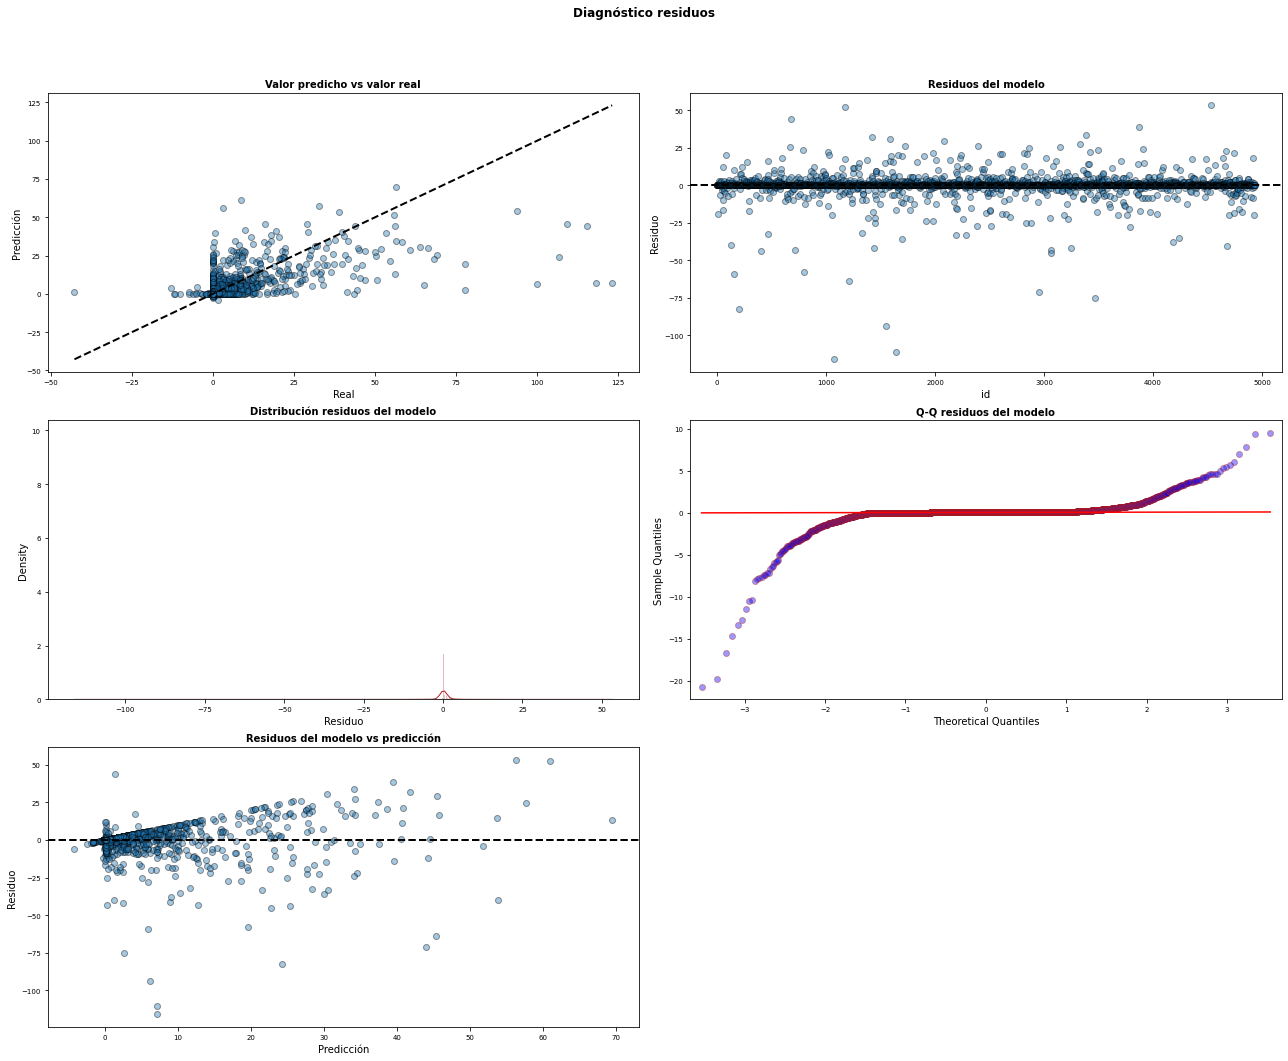

In [31]:
diag_residuos(y_test_oil, X_test_oil, model_oil)

<a id="34"></a> <br>
### 3.4. Optimización de hiperparámetros modelo GAS

In [32]:
# Optimización de hiperparámetros del modelo con grid search y cross validation

kfolds=KFold(n_splits=3,shuffle=True, random_state=42)

params_grid = { 
                "light_gbm__max_depth" : [5,10,50,80],
                "light_gbm__learning_rate": [0.01,0.05,1],
                "light_gbm__n_estimators" : [5,100,500] 
                              }

model_gas = GridSearchCV (pipe, params_grid, cv=kfolds, n_jobs = -1, scoring = "neg_root_mean_squared_error", refit = True)

In [33]:
# Seteado de parámetros de entrenamiento
fit_params={"light_gbm__categorical_feature": "auto" }

# Entrenamiento del modelo para oil
model_gas.fit(X_train_gas,y_train_gas, **fit_params)

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('ColumnDropper',
                                        ColumnDropper(columns=['ID_EVENTO'])),
                                       ('column_transformer',
                                        ColumnTransformer(transformers=[('standard_scaler',
                                                                         StandardScaler(),
                                                                         ['D3D',
                                                                          'D2D',
                                                                          'DZ',
                                                                          'AZ',
                                                                          'WHP_i',
                                                                          '#_BARRERAS'])])),
                                       ('light_gbm',
  

In [34]:
# Mejores hiperparámetros obtenidos por cross validation y grid search
model_gas.best_params_

{'light_gbm__learning_rate': 0.01,
 'light_gbm__max_depth': 5,
 'light_gbm__n_estimators': 500}

<a id="35"></a> <br>
### 3.5. Evaluación del modelo OIL

In [35]:
# Valor de RMSE en train
print("RMSE en train model GAS= ",mean_squared_error(y_train_gas, model_gas.predict(X_train_gas), squared=False))
# Valor de RMSE en test
print("RMSE en test model GAS= ",mean_squared_error(y_test_gas, model_gas.predict(X_test_gas), squared=False))

RMSE en train model GAS=  4.380833478383042
RMSE en test model GAS=  6.901653400664498


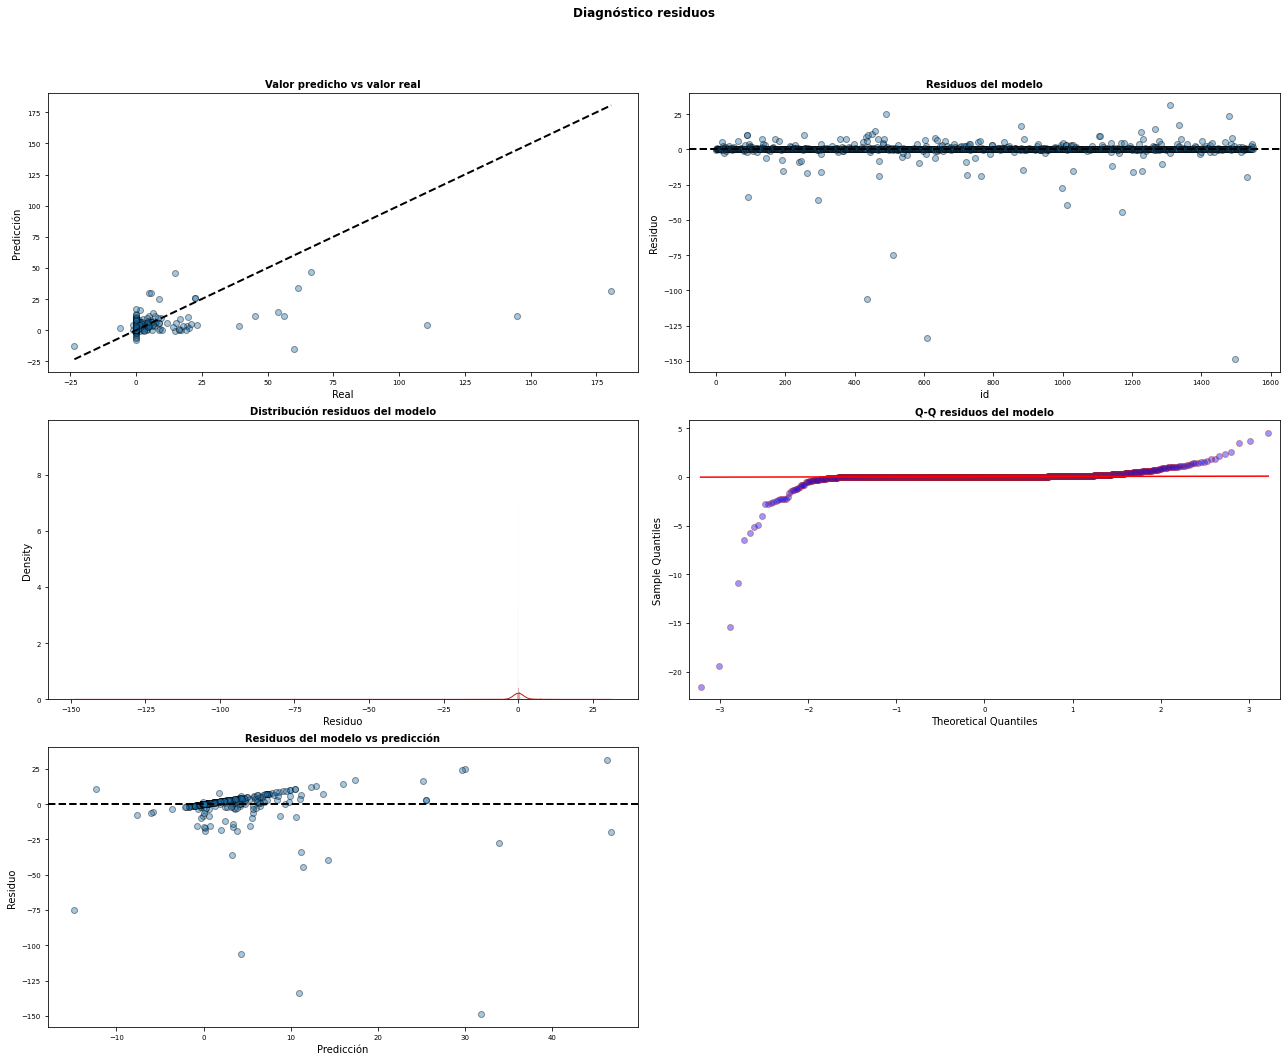

In [36]:
# Evaluación de residuos
diag_residuos(y_test_gas, X_test_gas, model_gas)